This notebook looks at using R for fitting linear models.

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div>

In [2]:
library(tidyverse)
library(scales)

library(modelr)
options(na.action = na.warn)

theme_set(theme_bw())
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
# read user pageview data
# > head(users)
# age gender daily.views
# 1  55 Female       163.4
# 2  19   Male       226.0
users <- read_tsv(gzfile('users.tsv.gz'))

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 102 rows containing non-finite values (stat_bin).”

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 102 rows containing non-finite values (stat_bin).”

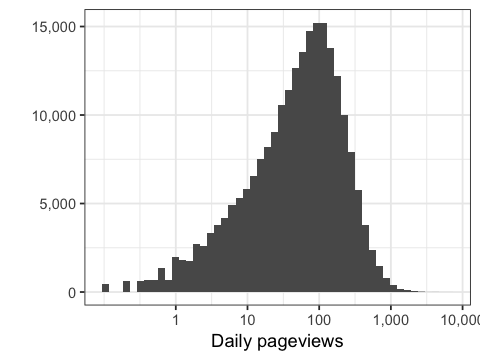

In [4]:
# histogram of the label/regressor variable:
ggplot(users, aes(x = daily.views)) +
  geom_histogram(bins = 50) +
  scale_x_log10(label=comma, breaks=10^(0:ceiling(log10(max(users$daily.views))))) +
  scale_y_continuous(label = comma) +
  xlab('Daily pageviews') +
  ylab('')
ggsave(filename='figures/daily_pageviews_dist.pdf', width=4, height=4)

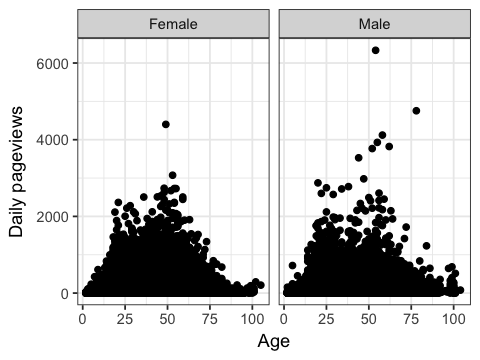

In [5]:
# plot all daily pageviews by age, faceted by gender
ggplot(data = users, aes(x = age, y = daily.views)) +
  geom_point() +
  facet_wrap(~ gender) +
  xlab('Age') +
  ylab('Daily pageviews')
ggsave(filename='figures/daily_pageviews_by_age_and_gender.pdf', width=8, height=4)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

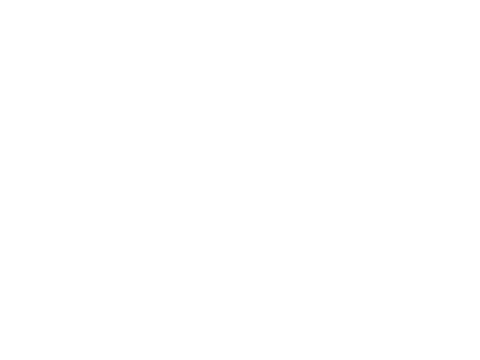

In [6]:
# add log-y axis, show smoothed curve instead of points
ggplot(users, aes(x = age, y = daily.views)) +
  geom_point() +
  geom_smooth(method = "gam") +
  scale_y_log10() +
  facet_wrap(~ gender) +
  xlab('Age') +
  ylab('Daily pageviews')

In [7]:
users <- filter(users, daily.views > 0)

In [8]:
# count views by age and gender
views_by_age_and_gender <- users %>%
  filter(age <= 90) %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            median_daily_views = median(daily.views))
head(views_by_age_and_gender)

age,gender,count,median_daily_views
2,Female,29,2.80
2,Male,30,4.85
3,Female,86,4.05
3,Male,90,4.10
4,Female,195,4.20
4,Male,187,5.00


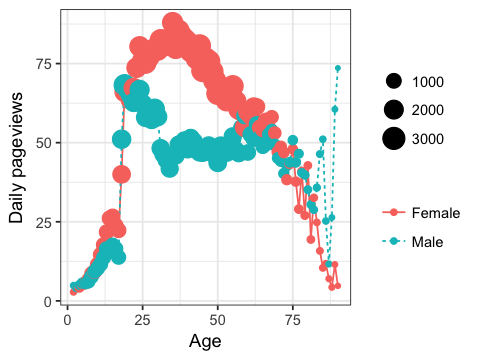

In [9]:
# plot median number of views by age and gender
ggplot(views_by_age_and_gender, aes(x = age, y = median_daily_views, color = gender)) +
  geom_line(aes(linetype=gender)) +
  geom_point(aes(size = count)) +
  xlab('Age') + 
  ylab('Daily pageviews') +
  theme(legend.title=element_blank())
ggsave(filename='figures/median_daily_pageviews_by_age_and_gender.pdf', width=8, height=4)

In [10]:
# note: look at log space
views_by_age_and_gender <- users %>%
  filter(age <= 90) %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            median_daily_views = median(daily.views),
            geom_mean_daily_views = 10^(mean(log10(daily.views))))
head(views_by_age_and_gender)

age,gender,count,median_daily_views,geom_mean_daily_views
2,Female,29,2.80,3.185450
2,Male,30,4.85,5.052371
3,Female,86,4.05,3.710554
3,Male,90,4.10,4.071081
4,Female,195,4.20,3.959044
4,Male,187,5.00,4.758086


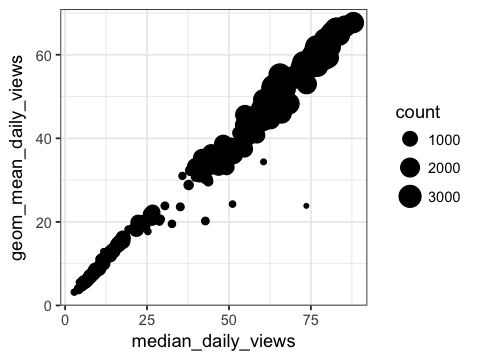

In [11]:
ggplot(views_by_age_and_gender, aes(x = median_daily_views, y = geom_mean_daily_views)) +
  geom_point(aes(size = count))

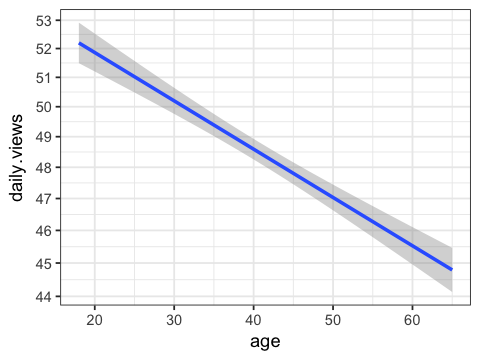

In [12]:
# filter to adults with reasonable data
model_data <- filter(users, age >= 18 & age <= 65)

# preview w/ a linear model w/ geom smooth
ggplot(model_data, aes(x = age, y = daily.views)) +
  #geom_point() +
  geom_smooth(method = "lm") +
  scale_y_log10(breaks = 1:100)

In [15]:
# fit and inspect model
model <- lm(log10(daily.views) ~ age, model_data)
model
summary(model)


Call:
lm(formula = log10(daily.views) ~ age, data = model_data)

Coefficients:
(Intercept)          age  
   1.743111    -0.001414  


ERROR: Error in chol2inv(Qr$qr[p1, p1, drop = FALSE]): LAPACK routines cannot be loaded


In [20]:
# add predictions (old)
plot_data <- model_data %>%
  distinct(age)
plot_data$predicted <- 10^predict(model, plot_data)
head(plot_data)

age,predicted
55,46.27342
19,52.02858
33,49.70996
38,48.90717
65,44.79090
20,51.85943


In [21]:
# add predictions (new, using modelr)
plot_data <- model_data %>%
  data_grid(age) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)
head(plot_data)

age,pred
18,52.19827
19,52.02858
20,51.85943
21,51.69084
22,51.52279
23,51.35529


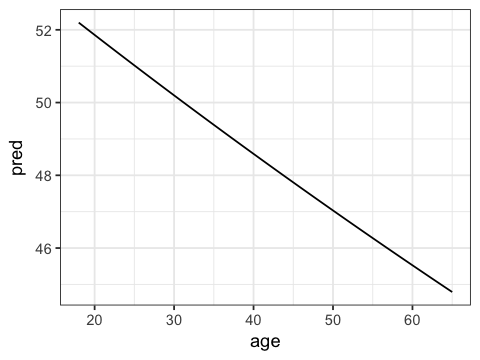

In [18]:
# plot predictions
ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line()

In [22]:
# add predictions (variation that includes actual (geometric) means from the data and predicted values
plot_data <- model_data %>%
  group_by(age) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)
head(plot_data)

age,count,geom_mean_daily_views,pred
18,3512,35.22038,52.19827
19,4765,47.23623,52.02858
20,4426,48.17692,51.85943
21,3864,47.62008,51.69084
22,3880,48.15020,51.52279
23,3975,49.47335,51.35529


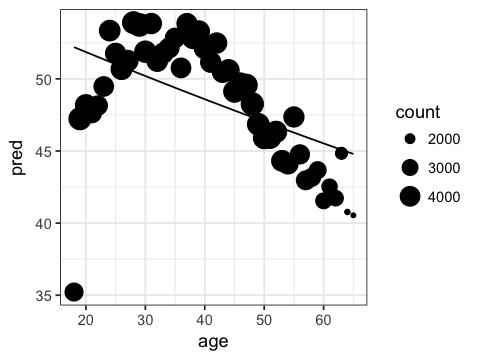

In [23]:
# plot predicted and actual values
ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count))

In [24]:
#
# change the model
#
model <- lm(log10(daily.views) ~ age + I(age^2), model_data)
model
summary(model)


Call:
lm(formula = log10(daily.views) ~ age + I(age^2), data = model_data)

Coefficients:
(Intercept)          age     I(age^2)  
  1.5062581    0.0116702   -0.0001619  


ERROR: Error in chol2inv(Qr$qr[p1, p1, drop = FALSE]): LAPACK routines cannot be loaded


In [25]:
# look at the model matrix if you like
M <- model.matrix(log10(daily.views) ~ age + I(age^2), model_data)
head(M)

,(Intercept),age,I(age^2)
1,1,55,3025
2,1,19,361
3,1,33,1089
4,1,38,1444
5,1,65,4225
6,1,20,400


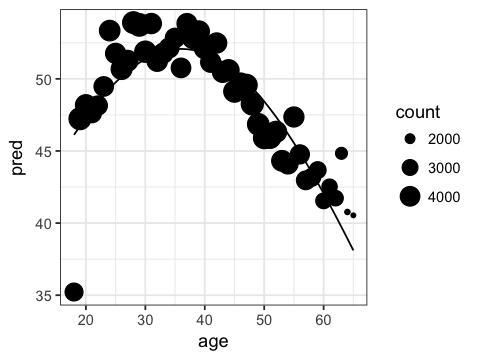

In [26]:
plot_data <- model_data %>%
  group_by(age) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count))

In [28]:
# repeat, adding gender

#
# change the model
#
model <- lm(log10(daily.views) ~ gender * (age + I(age^2)), model_data)
model
summary(model)


Call:
lm(formula = log10(daily.views) ~ gender * (age + I(age^2)), 
    data = model_data)

Coefficients:
        (Intercept)           genderMale                  age             I(age^2)       genderMale:age  genderMale:I(age^2)  
          1.3111470            0.5702782            0.0253549           -0.0003252           -0.0386190            0.0004570  


ERROR: Error in chol2inv(Qr$qr[p1, p1, drop = FALSE]): LAPACK routines cannot be loaded


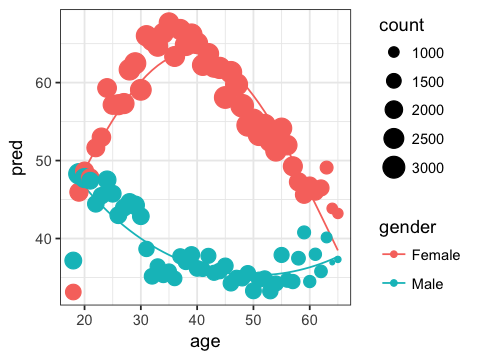

In [29]:
plot_data <- model_data %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

ggplot(plot_data, aes(x = age, y = pred, color = gender)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count))
ggsave(filename='figures/modeled_daily_pageviews_by_age_and_gender.pdf', width=8, height=4)